In [2]:
%matplotlib notebook 

This plot will take the speed of a representative experiment and show that I can extract behavioral parameters such as speed and that we can see how the animal performs a turn by just looking at the head speed

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
import json
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import matplotlib.ticker as plticker
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# This will change to the default sans-serif font
plt.rcParams["font.family"] = "sans-serif"
# This defines that the default will be Helvetica
plt.rcParams["font.sans-serif"] = "Helvetica"
import os
from pathlib import Path

In [4]:
home_path = os.getcwd()

In [5]:
# all the figures will be saved in this folder
target_path = Path('plots/')
os.chdir(home_path)
Path(target_path).mkdir(parents=True, exist_ok=True) 

<IPython.core.display.Javascript object>


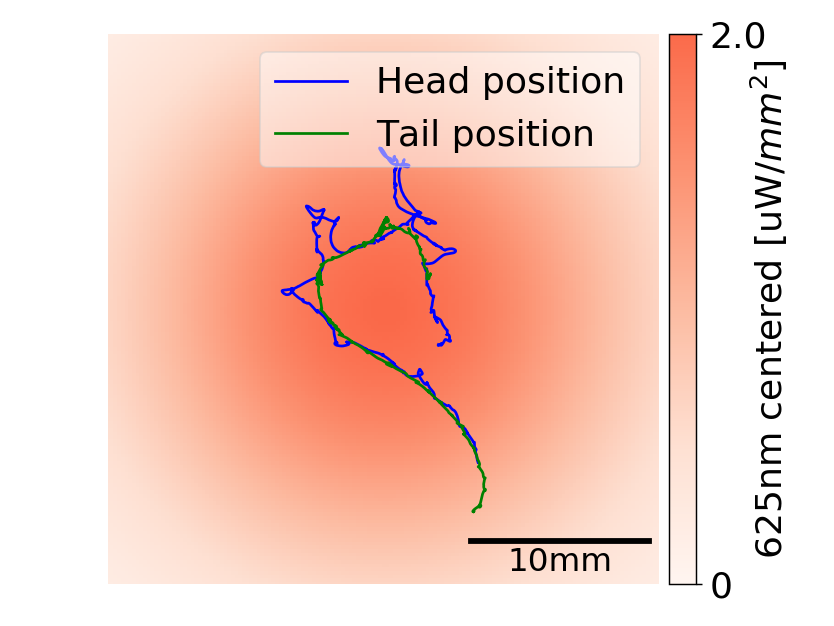

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [6]:
data_path_gauss = Path('data/MS379xMS133/gaussian_VR_arena/20.02.2018_19-09-45_MS379xMS133/')
os.chdir(home_path)
os.chdir(data_path_gauss)
background = imageio.imread('Background.jpg')
head_positions = np.load('SmA-T-heads.npy')
# read data
data = pd.read_csv('data.csv')
gauss_virtual_arena = np.genfromtxt('640x480_gaussian_centred_animal_pos[250,240,0.0].csv', delimiter=',')
with open(('experiment_settings.json'), 'r') as file:
    experiment_settings = json.load(file)
    pixel_per_mm = experiment_settings['Pixel per mm']
    recording_time = experiment_settings['Recording time']
    fps = experiment_settings['Framerate']

# define the stimulation
# get the virtual arena in uW/mm2
measured_light_intensity = 1.8
# max value in stim file is 40000
stimulation_in_uW_mm = data['stimulation']*(measured_light_intensity/40000)
# max value in stim file is 40000
gauss_arena_in_uW_mm = gauss_virtual_arena*(measured_light_intensity/40000)

# Get the maximum xy coordinate of the arena (different for different experiment as it depends on the position of the animal)
max_arena_indices_gauss = np.where(gauss_virtual_arena == np.amax(gauss_virtual_arena))
# just the the first one as there are only two anyways and it's only used to center the image
max_arena_indices_gauss = max_arena_indices_gauss[0][0], max_arena_indices_gauss[1][0]
#print(max_arena_index)

# only plot a fraction to see what's going on
start_plotting = 60 * fps # enter in seconds
end_plotting = 140 * fps # enter number in seconds

#############################
# Create a custom colormaps
# Evaluate an existing colormap from 0.5 (midpoint) to 1 (upper end)
cmap = plt.get_cmap('Reds')
colors = cmap(np.linspace(0, 0.5, cmap.N // 2))
# Create a new colormap from those colors
cmap_lower_half_reds= LinearSegmentedColormap.from_list('Lower Half', colors)
##############################

# create empty figure and axis
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_rasterization_zorder(1)
#ax.imshow(background, cmap='Greys_r')
# plot the virtual arena already in uw/mm
virtual_arena_plot_gauss = ax.imshow(gauss_arena_in_uW_mm, cmap=cmap_lower_half_reds,zorder=1)
# plot the head positions of the animal
#ax.scatter(x=data['X-Head'][start_plotting:end_plotting].rolling(int(fps/2), win_type='triang').mean(),
#          y=data['Y-Head'][start_plotting:end_plotting].rolling(int(fps/2), win_type='triang').mean(),
#          alpha = 1, s=1, label = 'Head position')
ax.plot(data['X-Head'][start_plotting:end_plotting].rolling(int(fps/2), win_type='triang').mean(),
        data['Y-Head'][start_plotting:end_plotting].rolling(int(fps/2), win_type='triang').mean(),
       color = 'b', alpha = 1, label='Head position',zorder = 2)
ax.plot(data['X-Tail'][start_plotting:end_plotting].rolling(int(fps/2), win_type='triang').mean(),
          data['Y-Tail'][start_plotting:end_plotting].rolling(int(fps/2), win_type='triang').mean(),
          alpha = 1, color = 'g', label = 'Tail position', zorder = 3)
#ax.scatter(x=head_positions[start_plotting:end_plotting,1], 
#           y=head_positions[start_plotting:end_plotting,0], 
#           color = 'b', alpha=0.2, s=1, label='Head position')
# to plot a solid line - doesn't look very good

distance_plotted_from_center = 75
ax.set_ylim(max_arena_indices_gauss[0]-distance_plotted_from_center,max_arena_indices_gauss[0]+distance_plotted_from_center)
ax.set_xlim(max_arena_indices_gauss[1]-distance_plotted_from_center,max_arena_indices_gauss[1]+distance_plotted_from_center)
ax.invert_yaxis()

# get the colorbar exactly the same size as the resulting window!
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad='2%')

cbar=fig.colorbar(virtual_arena_plot_gauss, 
                  ticks=[0,np.amax(gauss_arena_in_uW_mm)],
                  cax=cax,
                  fraction=0.046, 
                  pad=0.01)
# change fontsize, to see all parameters that can be changed: print(mpl.rcParams)
#mpl.rcParams['font.size'] = 
#cbar.set_label('625nm centered [' + r'$\mu$' + r'W/$mm^2$]', fontsize = 20)
cbar.set_label('625nm centered [u' + r'W/$mm^2$]', fontsize = 20)

ticklabs = cbar.ax.get_yticklabels()
#cbar.ax.set_yticklabels(ticklabs, fontsize=20)
cbar.ax.set_yticklabels([0,round(np.amax(gauss_arena_in_uW_mm))], fontsize=20)
cbar.ax.get_yaxis().labelpad = -10

# add scalebar
fontprops = fm.FontProperties(size=18)
scalebar = AnchoredSizeBar(ax.transData,
                           10*pixel_per_mm, '10mm', 
                           'lower right',
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)

ax.add_artist(scalebar)
# hide the ticks and the ticklabels
ax.axis('off')
# show the legend
leg = ax.legend(markerscale = 5, fontsize=20,framealpha=0.5)
# set alpha level of the marker
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
fig.tight_layout()
os.chdir(home_path)
os.chdir(target_path)
fig.savefig('Fig2b_zoom_gaussian.eps')#, rasterized=True, dpi=300)

In [7]:
def signal_filter(x_data, y_data, win_size, filter_name, pxmm, fps):
        if filter_name == 'Savitzky-Golay':
            x = savgol_filter(x_data.dropna(), win_size, 2)
            y = savgol_filter(y_data.dropna(), win_size, 2)
        else:
            x = x_data.rolling(window=win_size, win_type=filter_name).mean()
            y = y_data.rolling(window=win_size, win_type=filter_name).mean()


        speed = np.zeros(x_data.shape[0])
        for i in range(1, speed.shape[0]):
            try:
                # ((px/frames) / (px/mm)) * frames/second = mm/second
                speed[i] = (np.linalg.norm(np.array(x[i], y[i]) - np.array(x[i-1], y[i-1])) / pxmm) * fps
            except IndexError:
                pass
        return(speed)
    
# Need to filter the data somehow as the x/y coordinates we get from PiVR are recorded at 
# 30frames per second at a spatial resolution of anything between 2-5 pixel/mm. 
# I'll start by filtering the speed by the ratio of frames to pixel of the speed that 
# the animal can maximally do. This inuitively makes sense: We filter over a window 
# with the size we expect a pixel to stay at the same position if the animal moves
# at it's usual speed. 

# how fast does a larva move?
mm_per_second = 1
# window size should always be odd as to not shift the value
if int(fps/(mm_per_second*pixel_per_mm)) % 2 == 0:
    # even
    final_window_size = int((fps/(mm_per_second*pixel_per_mm)) + 1)
else:
    # odd
    final_window_size = int(fps/(mm_per_second*pixel_per_mm))


In [8]:
head_speed_filt = signal_filter(data['X-Head'], data['Y-Head'], final_window_size, 'triang', pixel_per_mm, fps)
head_speed_filt_pd = pd.Series(head_speed_filt)
tail_speed_filt = signal_filter(data['X-Tail'], data['Y-Tail'], final_window_size, 'triang', pixel_per_mm, fps)
tail_speed_filt_pd = pd.Series(tail_speed_filt)

In [17]:
# Calculate the theoretical sensory experience
integration_time = 2

# To calculate the theoretical sensory experience, it is necessary to filter the stimulation
# input as it's quite noisy.
# If we do not filter, we do not see the signal (sharp increase of Sensory Experience during
# headcasting)!
filtered_stimulation = stimulation_in_uW_mm.rolling(
                    window=int(fps), win_type='boxcar').mean().dropna()

sensory_exp = np.zeros((filtered_stimulation.shape[0]))
for i_inner in range(integration_time,sensory_exp.shape[0]-1):
    sensory_exp[i_inner] = 1/filtered_stimulation.iloc[i_inner]* \
        ((filtered_stimulation.iloc[i_inner] - \
          filtered_stimulation.iloc[i_inner-integration_time])/ \
         integration_time)

<IPython.core.display.Javascript object>


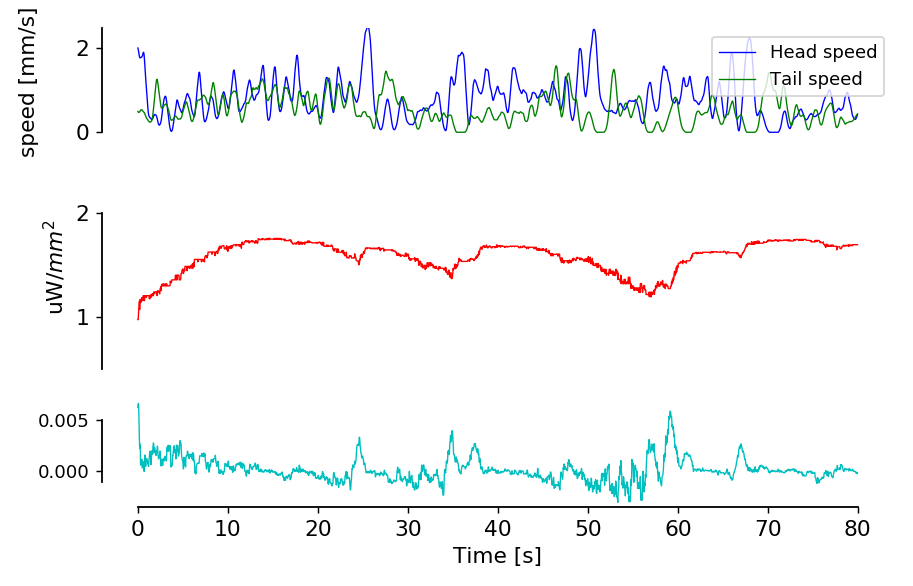

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [18]:
top_max_y = 2.5
bottom_max_y = 2
bottom_min_y = 1

x = np.arange(0,(end_plotting - start_plotting)/fps,1/fps)

fig = plt.figure(figsize=(7,4.5))
ax_top = fig.add_subplot(311)
ax_top.plot(x,
            head_speed_filt_pd.rolling(window=fps, win_type='triang').mean()[start_plotting:end_plotting], 
        label = 'Head speed', color = 'b', lw=0.75)
ax_top.plot(x,
            tail_speed_filt_pd.rolling(window=fps, win_type='triang').mean()[start_plotting:end_plotting], 
        label = 'Tail speed', color ='g', lw=0.75)

#ax_top.plot(head_speed_filt_pd.rolling(window=fps, win_type='triang').mean()[start_plotting:end_plotting]-
#        tail_speed_filt_pd.rolling(window=fps, win_type='triang').mean()[start_plotting:end_plotting],
#       label='Subtracted')
ax_top.tick_params(axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off)
ax_top.set_ylabel('speed [mm/s]', fontsize=12)
# change the location of the label
ax_top.get_yaxis().labelpad = 20
# can change x ticklabel size here
ax_top.tick_params(axis='y', labelsize=12)

ax_top.legend()


ax_middle = fig.add_subplot(312, sharex = ax_top)
ax_middle.plot(x,
               stimulation_in_uW_mm[start_plotting:end_plotting], 
               color ='r',
               lw=0.75)#,label = 'Stimulation [' + r'$\mu$' + r'W/$mm^2$]')
ax_middle.tick_params(axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off)

#ax_bottom.set_ylabel(r'$\mu$' + r'W/$mm^2$', fontsize=20)
ax_middle.set_ylabel('uW/$mm^2$', fontsize=12)

ax_bottom = fig.add_subplot(313, sharex=ax_top)
ax_bottom.plot(x,
               sensory_exp[start_plotting:end_plotting], 
               color='c', lw=0.75)
# label the x axis
ax_bottom.set_xlabel('Time [s]', fontsize=12)
# can change x ticklabel size here
ax_bottom.tick_params(axis='x', labelsize=12)
# can change y ticklable size here
ax_middle.tick_params(axis='y', labelsize=12)

# TOP PLOT SPINES
# Only draw spine between the y-ticks
ax_top.spines['left'].set_bounds(0, top_max_y)
ax_top.spines['right'].set_visible(False)
ax_top.spines['top'].set_visible(False)
ax_top.spines['bottom'].set_visible(False)
ax_top.spines['left'].set_linewidth(1)
# We change the fontsize of minor ticks label 
#ax_top.tick_params(axis='both', which='major', width=2, length =5)
#ax_top.tick_params(axis='both', which='minor', width =2,length =3)

# MIDDLE PLOT SPINES
# Only draw spine between the y-ticks
ax_middle.spines['left'].set_bounds(0.5, bottom_max_y)
ax_middle.spines['right'].set_visible(False)
ax_middle.spines['top'].set_visible(False)
ax_middle.spines['bottom'].set_visible(False)
ax_middle.spines['left'].set_linewidth(1)
# We change the fontsize of minor ticks label 
#ax_middle.tick_params(axis='both', which='major', width=2, length =5)
#ax_middle.tick_params(axis='both', which='minor', width =2,length =3)

# BOTTOM PLOT SPINES
# Only draw spine between the y-ticks
ax_bottom.spines['left'].set_bounds(-0.001, 0.005)
ax_bottom.spines['right'].set_visible(False)
ax_bottom.spines['top'].set_visible(False)
ax_bottom.spines['bottom'].set_linewidth(1)
ax_bottom.spines['left'].set_linewidth(1)
# We change the fontsize of minor ticks label 
#ax_bottom.tick_params(axis='both', which='major', width=2, length =5)
#ax_bottom.tick_params(axis='both', which='minor', width =2,length =3)
ax_bottom.spines['bottom'].set_bounds(0,80)
#ax_bottom.spines['left'].set_bounds(0,0.01)


ax_top.set_ylim(-0.1,top_max_y)

ax_middle.set_ylim(bottom_min_y-0.05, bottom_max_y)

fig.tight_layout()

os.chdir(home_path)
os.chdir(target_path)
fig.savefig('Fig2c_speed, stim, sensory.eps', rasterized=True, dpi=300)
